In [340]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/question-pairs-dataset/questions.csv


In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import warnings

In [342]:
warnings.filterwarnings('ignore')

In [364]:
df1=pd.read_csv('/kaggle/input/question-pairs-dataset/questions.csv')
df1

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404346,404346,789792,789793,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404347,404347,789794,789795,Do you believe there is life after death?,Is it true that there is life after death?,1
404348,404348,789796,789797,What is one coin?,What's this coin?,0
404349,404349,789798,789799,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [365]:
df=df1.sample(40000)

In [366]:
df.isnull().sum()


id              0
qid1            0
qid2            0
question1       0
question2       1
is_duplicate    0
dtype: int64

In [367]:
df=df.dropna()

In [368]:
df.duplicated().sum()


0

In [369]:
print(df['is_duplicate'].value_counts())
print(df['is_duplicate'].mean())

is_duplicate
0    25297
1    14702
Name: count, dtype: int64
0.3675591889797245


<Axes: xlabel='is_duplicate'>

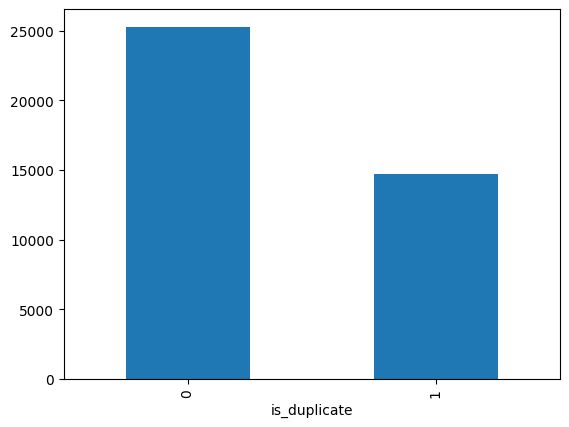

In [370]:
df['is_duplicate'].value_counts().plot(kind='bar')

In [371]:
qid=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
print(f'total unique questions {qid.unique().shape[0]}')
x=qid.value_counts()>1
print(f'repeated questions {x.sum()}')

total unique questions 79714
repeated questions 252


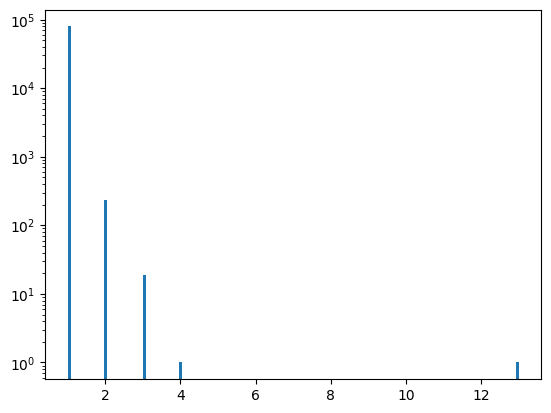

In [372]:
plt.hist(qid.value_counts().values,bins=150)
plt.yscale('log')
plt.show()

In [374]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz

# Initialize the PorterStemmer
stemmer = PorterStemmer()

def preprocess(text):
    text=text.lower().strip()
    # https://stackoverflow.com/a/19794953
    contractions = { 
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
        }

    q_decontracted = []

    for word in text.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(stemmer.stem(word))
   
    text = ' '.join(q_decontracted)
    text = BeautifulSoup(text)
    text = text.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    text = re.sub(pattern, ' ', text).strip()
    return text


In [375]:
preprocess("I've already! wasn't <b>done</b>?")

'i hav already  was not done'

In [376]:
df['question1']=df['question1'].apply(preprocess)
df['question2']=df['question2'].apply(preprocess)
df

,id,qid1,qid2,question1,question2,is_duplicate
304411,304411,597747,597748,how motiv are you at work what motiv you,what motiv you the most in your work,1
337926,337926,662476,662477,what would you do first if you won 100 000 000,what would you do if you won 100 000 000,1
276515,276515,543679,543680,what would be hi reaction if i give him a apol...,what would be hi reaction if i give him a lett...,1
68220,68220,135617,135618,what is it like to live in melbourne australia,what i it like to live in melbourne,1
388620,388620,759712,759713,how do i increas my follow on instagram,how will i boost my like on instagram,1
...,...,...,...,...,...,...
54132,54132,107719,107720,how do theist defin god,how would you defin god,0
157912,157912,312266,312267,is stainless steel brittl or ductil at room te...,whi are metal mostli ductil while ceram are br...,0
290739,290739,571229,571230,do girl onli love bad boys,attract interpersonal whi do some girl like...,0
173441,173441,342680,342681,photo editing how to decid which color to be ...,how do i move lightroom file to a new hard dri...,0


In [377]:
def basic_feature_con(row):
    q1=row['question1'].strip()
    q2=row['question2'].strip()
    
    features=[]
    features.append(len(q1))
    features.append(len(q2))

    features.append(len(q1.split(' ')))
    features.append(len(q2.split(' ')))
    
    features.append(len( set(q1.lower().split(' ')) & set(q2.lower().split(' '))))
                    
    features.append(round(features[-1]/(features[0]+features[1]),3))
    return features



In [378]:
features = df.apply(basic_feature_con, axis=1)

df["wl_q1"]       = list(map(lambda x: x[0], features))
df["wl_q2"]       = list(map(lambda x: x[1], features))
df['wc_q1']       = list(map(lambda x: x[2], features))
df['wc_q2']       = list(map(lambda x: x[3], features))
df['same_words']  = list(map(lambda x: x[4], features))
df['word_share']  = list(map(lambda x: x[5], features))

In [379]:
import seaborn as sns
df

,id,qid1,qid2,question1,question2,is_duplicate,wl_q1,wl_q2,wc_q1,wc_q2,same_words,word_share
304411,304411,597747,597748,how motiv are you at work what motiv you,what motiv you the most in your work,1,41,36,10,8,4,0.052
337926,337926,662476,662477,what would you do first if you won 100 000 000,what would you do if you won 100 000 000,1,47,41,12,11,9,0.102
276515,276515,543679,543680,what would be hi reaction if i give him a apol...,what would be hi reaction if i give him a lett...,1,55,59,12,13,11,0.096
68220,68220,135617,135618,what is it like to live in melbourne australia,what i it like to live in melbourne,1,47,35,10,8,7,0.085
388620,388620,759712,759713,how do i increas my follow on instagram,how will i boost my like on instagram,1,39,37,8,8,5,0.066
...,...,...,...,...,...,...,...,...,...,...,...,...
54132,54132,107719,107720,how do theist defin god,how would you defin god,0,23,23,5,5,3,0.065
157912,157912,312266,312267,is stainless steel brittl or ductil at room te...,whi are metal mostli ductil while ceram are br...,0,55,70,9,12,5,0.040
290739,290739,571229,571230,do girl onli love bad boys,attract interpersonal whi do some girl like...,0,26,55,6,12,4,0.049
173441,173441,342680,342681,photo editing how to decid which color to be ...,how do i move lightroom file to a new hard dri...,0,76,118,16,23,6,0.031


In [380]:
df.groupby('is_duplicate')[['wc_q1','wc_q2']].mean()

,wc_q1,wc_q2
is_duplicate,,
0,12.398427,12.781990
1,10.191335,10.173922


In [381]:
df.groupby('is_duplicate')['same_words'].mean()


is_duplicate
0    4.751275
1    5.950891
Name: same_words, dtype: float64

In [382]:
df.groupby('is_duplicate')['word_share'].mean()


is_duplicate
0    0.042693
1    0.062307
Name: word_share, dtype: float64

In [383]:
df.describe()


,id,qid1,qid2,is_duplicate,wl_q1,wl_q2,wc_q1,wc_q2,same_words,word_share
count,39999.000000,39999.000000,39999.000000,39999.000000,39999.000000,39999.000000,39999.00000,39999.000000,39999.000000,39999.000000
mean,201538.647616,390908.045751,389041.419835,0.367559,55.359409,55.849396,11.58719,11.823371,5.192205,0.049903
std,116415.221855,227867.744263,228164.863773,0.482146,27.945717,31.826874,6.22341,7.240960,3.259945,0.026165
min,1.000000,3.000000,4.000000,0.000000,0.000000,3.000000,1.00000,1.000000,0.000000,0.000000
25%,101068.500000,193892.000000,191581.000000,0.000000,37.000000,36.000000,8.00000,8.000000,3.000000,0.030500
50%,200600.000000,388405.000000,385695.000000,0.000000,48.000000,47.000000,10.00000,10.000000,5.000000,0.049000
75%,302645.000000,588251.000000,585882.000000,1.000000,67.000000,67.000000,14.00000,14.000000,7.000000,0.069000
max,404331.000000,789762.000000,789763.000000,1.000000,592.000000,1109.000000,147.00000,270.000000,29.000000,0.167000


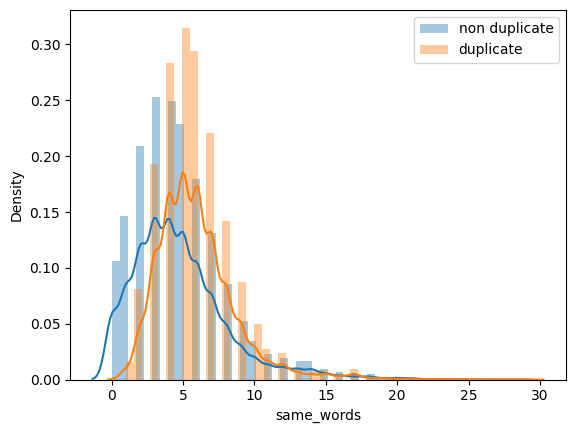

In [384]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(df[df['is_duplicate'] == 0]['same_words'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['same_words'],label='duplicate')
plt.legend()
plt.show()


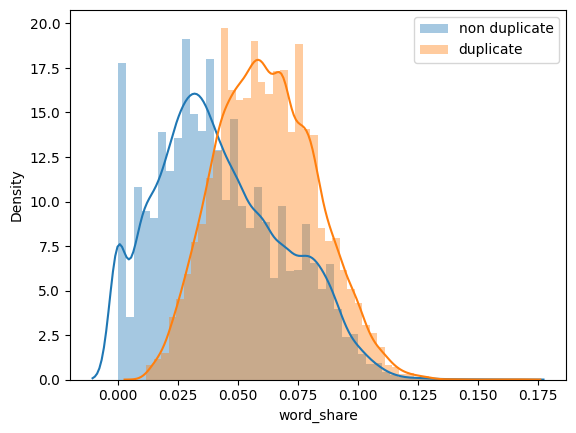

In [385]:
sns.distplot(df[df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()


In [386]:
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features


In [387]:
token_features = df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))


In [388]:
df

,id,qid1,qid2,question1,question2,is_duplicate,wl_q1,wl_q2,wc_q1,wc_q2,same_words,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
304411,304411,597747,597748,how motiv are you at work what motiv you,what motiv you the most in your work,1,41,36,10,8,4,0.052,0.999950,0.999950,0.399992,0.333328,0.499994,0.444440,0.0,0.0
337926,337926,662476,662477,what would you do first if you won 100 000 000,what would you do if you won 100 000 000,1,47,41,12,11,9,0.102,0.999967,0.749981,0.999980,0.999980,0.799992,0.727266,1.0,1.0
276515,276515,543679,543680,what would be hi reaction if i give him a apol...,what would be hi reaction if i give him a lett...,1,55,59,12,13,11,0.096,0.833319,0.833319,0.999983,0.857131,0.916659,0.846147,0.0,1.0
68220,68220,135617,135618,what is it like to live in melbourne australia,what i it like to live in melbourne,1,47,35,10,8,7,0.085,0.999967,0.749981,0.799984,0.799984,0.874989,0.777769,0.0,1.0
388620,388620,759712,759713,how do i increas my follow on instagram,how will i boost my like on instagram,1,39,37,8,8,5,0.066,0.333322,0.333322,0.799984,0.799984,0.624992,0.624992,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54132,54132,107719,107720,how do theist defin god,how would you defin god,0,23,23,5,5,3,0.065,0.666644,0.666644,0.499975,0.499975,0.599988,0.599988,1.0,1.0
157912,157912,312266,312267,is stainless steel brittl or ductil at room te...,whi are metal mostli ductil while ceram are br...,0,55,70,9,12,5,0.040,0.666656,0.499994,0.333322,0.333322,0.555549,0.416663,1.0,0.0
290739,290739,571229,571230,do girl onli love bad boys,attract interpersonal whi do some girl like...,0,26,55,6,12,4,0.049,0.599988,0.428565,0.999900,0.499975,0.666656,0.444440,1.0,0.0
173441,173441,342680,342681,photo editing how to decid which color to be ...,how do i move lightroom file to a new hard dri...,0,76,118,16,23,6,0.031,0.166664,0.083333,0.571420,0.499994,0.333331,0.238094,0.0,0.0


In [389]:


def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    
    return length_features
    


In [390]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))

In [391]:
df

,id,qid1,qid2,question1,question2,is_duplicate,wl_q1,wl_q2,wc_q1,wc_q2,...,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len
304411,304411,597747,597748,how motiv are you at work what motiv you,what motiv you the most in your work,1,41,36,10,8,...,0.999950,0.999950,0.399992,0.333328,0.499994,0.444440,0.0,0.0,1.0,8.5
337926,337926,662476,662477,what would you do first if you won 100 000 000,what would you do if you won 100 000 000,1,47,41,12,11,...,0.999967,0.749981,0.999980,0.999980,0.799992,0.727266,1.0,1.0,1.0,10.5
276515,276515,543679,543680,what would be hi reaction if i give him a apol...,what would be hi reaction if i give him a lett...,1,55,59,12,13,...,0.833319,0.833319,0.999983,0.857131,0.916659,0.846147,0.0,1.0,1.0,12.5
68220,68220,135617,135618,what is it like to live in melbourne australia,what i it like to live in melbourne,1,47,35,10,8,...,0.999967,0.749981,0.799984,0.799984,0.874989,0.777769,0.0,1.0,1.0,8.5
388620,388620,759712,759713,how do i increas my follow on instagram,how will i boost my like on instagram,1,39,37,8,8,...,0.333322,0.333322,0.799984,0.799984,0.624992,0.624992,1.0,1.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54132,54132,107719,107720,how do theist defin god,how would you defin god,0,23,23,5,5,...,0.666644,0.666644,0.499975,0.499975,0.599988,0.599988,1.0,1.0,0.0,5.0
157912,157912,312266,312267,is stainless steel brittl or ductil at room te...,whi are metal mostli ductil while ceram are br...,0,55,70,9,12,...,0.666656,0.499994,0.333322,0.333322,0.555549,0.416663,1.0,0.0,3.0,10.5
290739,290739,571229,571230,do girl onli love bad boys,attract interpersonal whi do some girl like...,0,26,55,6,12,...,0.599988,0.428565,0.999900,0.499975,0.666656,0.444440,1.0,0.0,3.0,7.5
173441,173441,342680,342681,photo editing how to decid which color to be ...,how do i move lightroom file to a new hard dri...,0,76,118,16,23,...,0.166664,0.083333,0.571420,0.499994,0.333331,0.238094,0.0,0.0,6.0,18.0


In [392]:

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features


In [393]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [36]:
df

,question1,question2,is_duplicate,wl_q1,wl_q2,wc_q1,wc_q2,same_words,word_share,cwc_min,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
336816,how did adolf hitler view nativ americans,whi did hitler like nativ american and asians,0,41,45,7,8,3,0.035,0.399992,...,0.428565,0.374995,0,0,1,7.5,72,76,67,70
214538,is prostitut in saudi arabia illegal,doe prostitut thrive in saudi arabia,1,36,36,6,6,4,0.056,0.749981,...,0.666656,0.666656,0,0,0,6.0,72,74,75,82
119714,what are chatbots how can i build one,what are some of the latest technolog gear tow...,0,38,78,9,13,2,0.017,0.000000,...,0.249997,0.153845,0,1,5,10.5,43,47,45,45
6462,where are the best place to train to becom a s...,where are the best place to train to becom a s...,0,63,62,13,13,11,0.088,0.833319,...,0.846147,0.846147,0,1,0,13.0,93,94,93,94
304093,career advice whi are scientist not paid such...,whi are film actor so highli paid wherea scien...,0,94,75,18,14,4,0.024,0.299997,...,0.285712,0.235293,0,0,3,15.5,47,49,63,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283273,do husband need to hand hi salari to the wive ...,in western marri life doe the husband have to...,1,57,77,12,17,6,0.045,0.499994,...,0.499996,0.374998,0,0,4,14.0,58,70,68,74
300696,what is the best optic illusion,what are some optic illusions,1,31,29,6,5,2,0.033,0.499975,...,0.399992,0.333328,0,1,1,5.5,77,72,80,80
378960,how india languag cultur is deacying,which is the best instut to learn busi analyt ...,0,37,77,7,15,2,0.018,0.000000,...,0.166664,0.071428,0,0,8,10.0,37,46,36,36
392288,what is a dvdscr xvid 1cdrip,how do you convert xvid file to mp4,0,32,36,10,9,2,0.029,0.333322,...,0.166664,0.124998,0,0,2,7.0,44,44,44,44


In [ ]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')


In [ ]:
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')


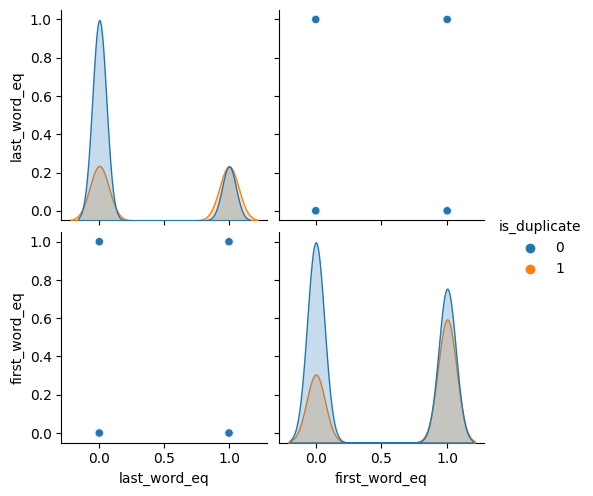

In [396]:
sns.pairplot(df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')


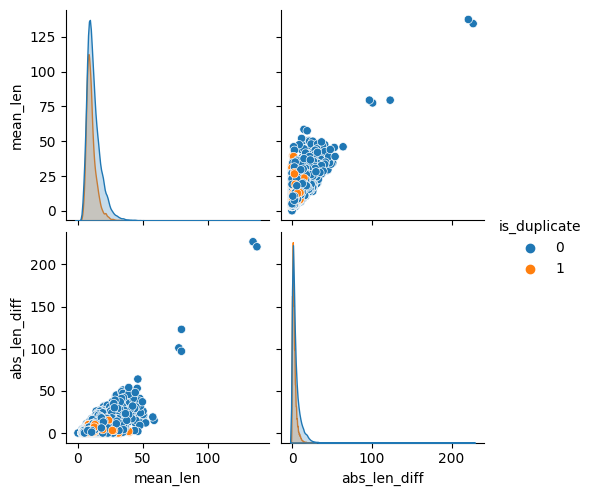

In [397]:
sns.pairplot(df[['mean_len', 'abs_len_diff','is_duplicate']],hue='is_duplicate')


In [ ]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')


In [400]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()
x=sc.fit_transform(df[ ['wl_q1', 'wl_q2', 'wc_q1',
       'wc_q2', 'same_words', 'word_share', 'cwc_min', 'cwc_max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'fuzz_ratio', 'fuzz_partial_ratio',
       'token_sort_ratio', 'token_set_ratio']])
y=df['is_duplicate']

In [195]:
x

array([[0.14925373, 0.13076923, 0.0754717 , ..., 0.65217391, 0.58227848,
        0.61038961],
       [0.12437811, 0.09615385, 0.05660377, ..., 0.62318841, 0.6835443 ,
        0.76623377],
       [0.13432836, 0.25769231, 0.11320755, ..., 0.23188406, 0.30379747,
        0.28571429],
       ...,
       [0.12935323, 0.25384615, 0.0754717 , ..., 0.2173913 , 0.18987342,
        0.16883117],
       [0.10447761, 0.09615385, 0.13207547, ..., 0.1884058 , 0.29113924,
        0.27272727],
       [0.23880597, 0.13461538, 0.16981132, ..., 0.27536232, 0.43037975,
        0.42857143]])

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rfc1=RandomForestClassifier(n_estimators=100)
rfc1.fit(x_train,y_train)
y_pred=rfc.predict(x_test)
accuracy_score(y_test,y_pred)


In [198]:
from xgboost import XGBClassifier
xgb=XGBClassifier()
xgb.fit(x_train,y_train)
y_pred1=xgb.predict(x_test)
accuracy_score(y_test,y_pred1)

0.714

In [204]:
from sklearn.manifold import TSNE
tsne2d=TSNE(n_components=2,n_iter=1000,n_jobs=-1)
t=tsne2d.fit_transform(x)

In [ ]:
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py
py.init_notebook_mode(connected=True)

trace1 = go.Scatter3d(
    x=t[:,0],
    y=t[:,1],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='2DBubble')

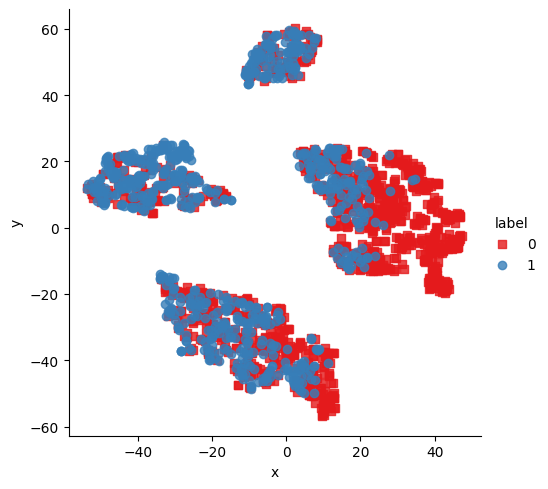

In [208]:

x_df = pd.DataFrame({'x':t[:,0], 'y':t[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=x_df, x='x', y='y', hue='label', fit_reg=False,palette="Set1",markers=['s','o'])

### Using Bag of words Vectorizer

In [401]:
t_questions=df['question1'].tolist()+df['question2'].tolist()

In [402]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=2000)
arr=cv.fit_transform(t_questions)
q1,q2=np.vsplit(arr.toarray(),2)

In [403]:
new_df=pd.concat([pd.DataFrame(q1),pd.DataFrame(q2)],axis=1,ignore_index=1)
new_df

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,2,0,1,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39994,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
39995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [166]:
df.columns

Index(['question1', 'question2', 'is_duplicate', 'wl_q1', 'wl_q2', 'wc_q1',
       'wc_q2', 'same_words', 'word_share', 'cwc_min', 'cwc_max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'fuzz_ratio', 'fuzz_partial_ratio',
       'token_sort_ratio', 'token_set_ratio'],
      dtype='object')

In [404]:
feature_df=pd.DataFrame(df[['wl_q1', 'wl_q2', 'wc_q1',
       'wc_q2', 'same_words', 'word_share', 'cwc_min', 'cwc_max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'fuzz_ratio', 'fuzz_partial_ratio',
       'token_sort_ratio', 'token_set_ratio']])
feature_df=feature_df.reset_index(drop=1)
feature_df

,wl_q1,wl_q2,wc_q1,wc_q2,same_words,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,41,36,10,8,4,0.052,0.999950,0.999950,0.399992,0.333328,0.499994,0.444440,0.0,0.0,1.0,8.5,60,56,74,78
1,47,41,12,11,9,0.102,0.999967,0.749981,0.999980,0.999980,0.799992,0.727266,1.0,1.0,1.0,10.5,93,85,93,100
2,55,59,12,13,11,0.096,0.833319,0.833319,0.999983,0.857131,0.916659,0.846147,0.0,1.0,1.0,12.5,84,87,96,96
3,47,35,10,8,7,0.085,0.999967,0.749981,0.799984,0.799984,0.874989,0.777769,0.0,1.0,1.0,8.5,85,97,86,97
4,39,37,8,8,5,0.066,0.333322,0.333322,0.799984,0.799984,0.624992,0.624992,1.0,1.0,0.0,8.0,68,65,63,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39994,23,23,5,5,3,0.065,0.666644,0.666644,0.499975,0.499975,0.599988,0.599988,1.0,1.0,0.0,5.0,70,70,61,72
39995,55,70,9,12,5,0.040,0.666656,0.499994,0.333322,0.333322,0.555549,0.416663,1.0,0.0,3.0,10.5,59,65,59,75
39996,26,55,6,12,4,0.049,0.599988,0.428565,0.999900,0.499975,0.666656,0.444440,1.0,0.0,3.0,7.5,49,77,56,76
39997,76,118,16,23,6,0.031,0.166664,0.083333,0.571420,0.499994,0.333331,0.238094,0.0,0.0,6.0,18.0,47,50,51,55


In [405]:
new_df=pd.concat([new_df,feature_df],axis=1)
new_df

,0,1,2,3,4,5,6,7,8,9,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,0,0,0,0,0,0,0,0,0,0,...,0.499994,0.444440,0.0,0.0,1.0,8.5,60,56,74,78
1,2,0,1,0,0,0,0,0,0,0,...,0.799992,0.727266,1.0,1.0,1.0,10.5,93,85,93,100
2,0,0,0,0,0,0,0,0,0,0,...,0.916659,0.846147,0.0,1.0,1.0,12.5,84,87,96,96
3,0,0,0,0,0,0,0,0,0,0,...,0.874989,0.777769,0.0,1.0,1.0,8.5,85,97,86,97
4,0,0,0,0,0,0,0,0,0,0,...,0.624992,0.624992,1.0,1.0,0.0,8.0,68,65,63,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39994,0,0,0,0,0,0,0,0,0,0,...,0.599988,0.599988,1.0,1.0,0.0,5.0,70,70,61,72
39995,0,0,0,0,0,0,0,0,0,0,...,0.555549,0.416663,1.0,0.0,3.0,10.5,59,65,59,75
39996,0,0,0,0,0,0,0,0,0,0,...,0.666656,0.444440,1.0,0.0,3.0,7.5,49,77,56,76
39997,0,0,0,0,0,0,0,0,0,0,...,0.333331,0.238094,0.0,0.0,6.0,18.0,47,50,51,55


In [172]:
x_train1

,0,1,2,3,4,5,6,7,8,9,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
1619,0,0,0,0,0,0,0,0,0,0,...,0.333328,0.222220,0,0,3,7.5,62,74,64,66
504,0,0,0,0,0,0,0,0,0,0,...,0.333328,0.199998,0,0,4,8.0,45,59,48,58
860,0,0,0,0,0,0,0,0,0,0,...,0.888879,0.615380,1,1,4,11.0,81,74,76,92
1917,0,0,0,0,0,0,0,0,0,0,...,0.666659,0.599994,1,1,1,9.5,75,72,73,85
10,0,0,0,0,0,0,0,0,0,0,...,0.818174,0.818174,0,1,0,11.0,82,86,89,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0,0,0,0,0,0,0,0,0,0,...,0.090908,0.083333,0,0,1,11.5,42,47,44,42
1598,0,0,0,0,0,0,0,0,0,0,...,0.571426,0.521737,0,0,2,22.0,42,42,65,75
1519,0,0,0,0,0,0,0,0,0,0,...,0.599988,0.499992,0,1,1,5.5,71,82,68,81
1776,0,0,0,0,0,0,0,0,0,0,...,0.714276,0.499995,1,1,3,8.5,71,67,64,80


In [407]:
new_df.columns = new_df.columns.astype(str)

In [409]:
from sklearn.model_selection import train_test_split
x_train1,x_test1,y_train1,y_test1=train_test_split(new_df,y,test_size=0.20)

In [410]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rfc=RandomForestClassifier(n_estimators=200)
rfc.fit(x_train1,y_train1)
y_pred=rfc.predict(x_test1)
accuracy_score(y_test1,y_pred)


0.7855

In [186]:
from xgboost import XGBClassifier
xgb=XGBClassifier()
xgb.fit(x_train1,y_train1)
y_pred1=xgb.predict(x_test1)
accuracy_score(y_test1,y_pred1)

0.725

In [339]:
rfc.predict(query_preproces(q1,q2))

array([0])

## Handling Input query

In [411]:

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz

# Initialize the PorterStemmer
stemmer = PorterStemmer()

def preprocess(text):
    text=text.lower().strip()
    # https://stackoverflow.com/a/19794953
    contractions = { 
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
        }

    q_decontracted = []

    for word in text.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(stemmer.stem(word))
   
    text = ' '.join(q_decontracted)
    text = BeautifulSoup(text)
    text = text.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    text = re.sub(pattern, ' ', text).strip()
    return text

def query_preproces(q1,q2):
    
    q1=preprocess(q1)
    q2=preprocess(q2)
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    features=[]

    features.append(len(q1))
    features.append(len(q2))

    features.append(len(q1_tokens))
    features.append(len(q2_tokens))
    
    features.append(len( set(q1_tokens) & set(q2_tokens)))
                    
    features.append(round(features[-1]/(features[0]+features[1]),3))
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    
    

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    features.append(common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV))
    features.append(common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV))
    features.append(common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV))
    features.append(common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV))
    features.append(common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV))
    features.append(common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV))
    
    # Last word of both question is same or not
    features.append(int(q1_tokens[-1] == q2_tokens[-1]))
    
    # First word of both question is same or not
    features.append(int(q1_tokens[0] == q2_tokens[0]))

    
    # Absolute length features
    features.append(abs(len(q1_tokens) - len(q2_tokens)))
    
    #Average Token Length of both Questions
    features.append((len(q1_tokens) + len(q2_tokens))/2)
    
    # Fuzzy Features


    
    # fuzz_ratio
    features.append(fuzz.QRatio(q1, q2))

    # fuzz_partial_ratio
    features.append(fuzz.partial_ratio(q1, q2))

    # token_sort_ratio
    features.append(fuzz.token_sort_ratio(q1, q2))

    # token_set_ratio
    features.append(fuzz.token_set_ratio(q1, q2))
    q1_bow=cv.transform([q1])
    q2_bow=cv.transform([q2])
    return np.hstack([q1_bow.toarray(),q2_bow.toarray(),np.array(features).reshape(1,20)])
    
    

    
    

In [412]:
import pickle as pkl
pkl.dump(rfc,open('model.pkl','wb'))
pkl.dump(cv,open('cv.pkl','wb'))

In [ ]:
'''
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz

# Initialize the PorterStemmer
stemmer = PorterStemmer()

def preprocess(text):
    text=text.lower().strip()
    # https://stackoverflow.com/a/19794953
    contractions = { 
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
        }

    q_decontracted = []

    for word in text.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(stemmer.stem(word))
   
    text = ' '.join(q_decontracted)
    text = BeautifulSoup(text)
    text = text.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    text = re.sub(pattern, ' ', text).strip()
    return text

def data_preproces(row):
    q1=row['question1']
    q2=row['question2']
    
    q1=preprocess(q1)
    q2=preprocess(q2)
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    features=[]

    features.append(len(q1))
    features.append(len(q2))

    features.append(len(q1_tokens))
    features.append(len(q2_tokens))
    
    features.append(len( set(q1_tokens) & set(q2_tokens)))
                    
    features.append(round(features[-1]/(features[0]+features[1]),3))
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    
    

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    features.append(common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV))
    features.append(common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV))
    features.append(common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV))
    features.append(common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV))
    features.append(common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV))
    features.append(common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV))
    
    # Last word of both question is same or not
    features.append(int(q1_tokens[-1] == q2_tokens[-1]))
    
    # First word of both question is same or not
    features.append(int(q1_tokens[0] == q2_tokens[0]))

    
    # Absolute length features
    features.append(abs(len(q1_tokens) - len(q2_tokens)))
    
    #Average Token Length of both Questions
    features.append((len(q1_tokens) + len(q2_tokens))/2)
    
    # Fuzzy Features


    
    # fuzz_ratio
    features.append(fuzz.QRatio(q1, q2))

    # fuzz_partial_ratio
    features.append(fuzz.partial_ratio(q1, q2))

    # token_sort_ratio
    features.append(fuzz.token_sort_ratio(q1, q2))

    # token_set_ratio
    features.append(fuzz.token_set_ratio(q1, q2))
    q1_bow=cv.transform([q1])
    q2_bow=cv.transform([q2])
    return np.hstack([q1_bow.toarray(),q2_bow.toarray(),np.array(features).reshape(1,20)])
   ''' 
    
'''features = temp.apply(data_preproces, axis=1)

temp["wl_q1"]       = list(map(lambda x: x[0], features))
temp["wl_q2"]       = list(map(lambda x: x[1], features))
temp['wc_q1']       = list(map(lambda x: x[2], features))
temp['wc_q2']       = list(map(lambda x: x[3], features))
temp['same_words']  = list(map(lambda x: x[4], features))
temp['word_share']  = list(map(lambda x: x[5], features))



temp["cwc_min"]       = list(map(lambda x: x[6],  features))
temp["cwc_max"]       = list(map(lambda x: x[7],  features))
temp["csc_min"]       = list(map(lambda x: x[8],  features))
temp["csc_max"]       = list(map(lambda x: x[9],  features))
temp["ctc_min"]       = list(map(lambda x: x[10],  features))
temp["ctc_max"]       = list(map(lambda x: x[11],  features))
temp["last_word_eq"]  = list(map(lambda x: x[12],  features))
temp["first_word_eq"] = list(map(lambda x: x[13],  features))


temp['abs_len_diff'] = list(map(lambda x: x[14],  features))
temp['mean_len'] = list(map(lambda x: x[15],  features))


# Creating new feature columns for fuzzy features
temp['fuzz_ratio'] = list(map(lambda x: x[16],  features))
temp['fuzz_partial_ratio'] = list(map(lambda x: x[17],  features))
temp['token_sort_ratio'] = list(map(lambda x: x[18],  features))
temp['token_set_ratio'] = list(map(lambda x: x[19],  features))'''  
    